# Developer Tools / Signed Random Walk

### `import packages.needed` 

In [1]:
%matplotlib inline
#
from lrgsglib.shared import *
from lrgsglib.config.utils import log_binning
from lrgsglib.core import Lattice2D, SignedRW, move_to_rootf
from lrgsglib.Ccore.stocproc.signedRw.Lattices import random_walker
#

In [2]:
move_to_rootf()
#
nbPath = os.path.join('ipynb')
nbdatPath = os.path.join(nbPath, 'data')
nbpltPath = os.path.join(nbdatPath, 'plot')
os.makedirs(nbpltPath, exist_ok=True)
nbmplssPath = os.path.join('ipynb', 'nb_plotsheet.mplstyle')
#
plt.style.use(nbmplssPath)

Current working directory: /home/opisthofulax/PhD/projects/complex-networks/lrgsglib


## C++ (boost) implementation

### Lattice 2D: distributions of distances

In [3]:
setting = {0: [fr'$x_0 = (L/2, L/2)$', 'pbc'],
           1: [fr'$x_0 = (L/2, L/2)$', 'fbc'],
           2: [fr'$x_0 = \mathrm{{rand}}$', 'pbc'],
           3: [fr'$x_0 = \mathrm{{rand}}$', 'fbc']
}
mode = 2
#
side = 100
geo = 'triangular'
navg1 = 5000
navg2 = navg1
pflipList = [0.001, 0.01, 0.025, 0.05, 0.08, 0.1, 0.12, 0.15, 
             0.18, 0.25, 0.5, 0.75, 0.9]

In [4]:
for geo in ['squared', 'triangular']:
    for mode in list(setting.keys()):
        def assign_random_signs(edge_list, p_flip):
            rand_p = np.random.rand(len(edge_list))
            signs = [1 if p_flip < rand_p[i] else -1 for i in range(len(edge_list))]
            return signs
        #
        def run_single_realization(edgeList, signs, width, height, coordination_number, Nnodes):
            walker = random_walker.RandomWalker(edgeList, signs, width, height, coordination_number)
            match mode:
                case 0|1:
                    start_node = width * (height // 2) + (width // 2)
                case 2|3:
                    start_node = np.random.randint(0, Nnodes-1)
            walker.walk(start_node)
            return walker.get_step_distance(), walker.get_euclidean_distance()
        match mode:
            case 1|3:
                pbc = False
            case 0|2:
                pbc = True
        l = Lattice2D(side, geo=geo, pbc=pbc)
        #
        edgeList = list(l.GraphReprDict['H'].edges())
        nodeList = l.nodeList
        euD = {}
        stD = {}
        for pflip in pflipList:
            step_distances = []
            euclidean_distances = []
            stopped_nodes = []
            for _ in range(navg2):
                signs = assign_random_signs(edgeList, pflip)
                stp, euc = run_single_realization(edgeList, signs, l.side1, l.side2, l.z, l.N)
                step_distances.append(stp)
                euclidean_distances.append(euc)
            euD[pflip] = euclidean_distances
            stD[pflip] = step_distances
        fname = f'Lattice2DRw_{side}_m{mode}_{geo}_{navg2}.png'
        strTit = fr'Setting: {side} {geo}, {' -- '.join(setting[mode])} \
            $n_{{\mathrm{{a}}}}= {navg2}$'
        #
        fig, ax = plt.subplots(ncols=2)
        fig.suptitle(strTit, fontsize=24, y=.9)
        #
        ax[0].set_xlabel(r'Displacement $\abs{x-x_0}$')
        ax[1].set_xlabel(r'$p$')
        ax[0].set_ylabel(r'$P(x)$')
        ax[1].set_ylabel(r'$x_{\max}/L$, $\sigma_x/L$')
        #
        # ax[1].set_xscale('log')
        #
        for pflip in pflipList:
            x, pdf = powerlaw.pdf(euD[pflip], xmin=1)
            ax[0].loglog(x[1:], pdf, label=f'$p = {pflip:.3}$')
            ax[1].plot(pflip, np.max(euD[pflip])/l.side1, 'kh')
            ax[1].plot(pflip, np.std(euD[pflip])/l.side1, 'rh')

        # ax[1].plot(pflipList,0.01*np.array(pflipList)**(-1/1.75), '--', label=r'$\propto p^{-1/1.75}$')
        ax[1].axvline(l.p_c, color='purple', linestyle='--', label=fr'$p={l.p_c}$')

        ax[0].legend(ncols=3)
        ax[1].legend()
        fig.tight_layout()
        fig.savefig(os.path.join(nbpltPath, fname), bbox_inches='tight', dpi=300)
        plt.close()

In [4]:
mode = 2
#
side = 50
geo = 'triangular'
navg1 = 100
navg2 = navg1
pflipList = [0.01, 0.025, 0.05, 0.08, 0.1, 0.12, 0.15, 
             0.18, 0.25, 0.5, 0.75, 0.9]

In [5]:
def assign_random_signs(edge_list, p_flip):
    rand_p = np.random.rand(len(edge_list))
    signs = [1 if p_flip < rand_p[i] else -1 for i in range(len(edge_list))]
    return signs
#
def run_single_realization(edgeList, signs, width, height, coordination_number, Nnodes):
    walker = random_walker.RandomWalker(edgeList, signs, width, height, coordination_number)
    match mode:
        case 0|1:
            start_node = width * (height // 2) + (width // 2)
        case 2|3:
            start_node = np.random.randint(0, Nnodes-1)
    walker.walk(start_node)
    return walker.get_step_distance(), walker.get_euclidean_distance()

In [6]:
match mode:
    case 1|3:
        pbc = False
    case 0|2:
        pbc = True
l = Lattice2D(side, geo=geo, pbc=pbc)
#
edgeList = list(l.GraphReprDict['H'].edges())
nodeList = l.nodeList

In [7]:
euD = {}
stD = {}
for pflip in pflipList:
    print(pflip)
    step_distances = []
    euclidean_distances = []
    stopped_nodes = []
    for _ in range(navg2):
        signs = assign_random_signs(edgeList, pflip)
        stp, euc = run_single_realization(edgeList, signs, l.side1, l.side2, l.z, l.N)
        step_distances.append(stp)
        euclidean_distances.append(euc)
    euD[pflip] = euclidean_distances
    stD[pflip] = step_distances

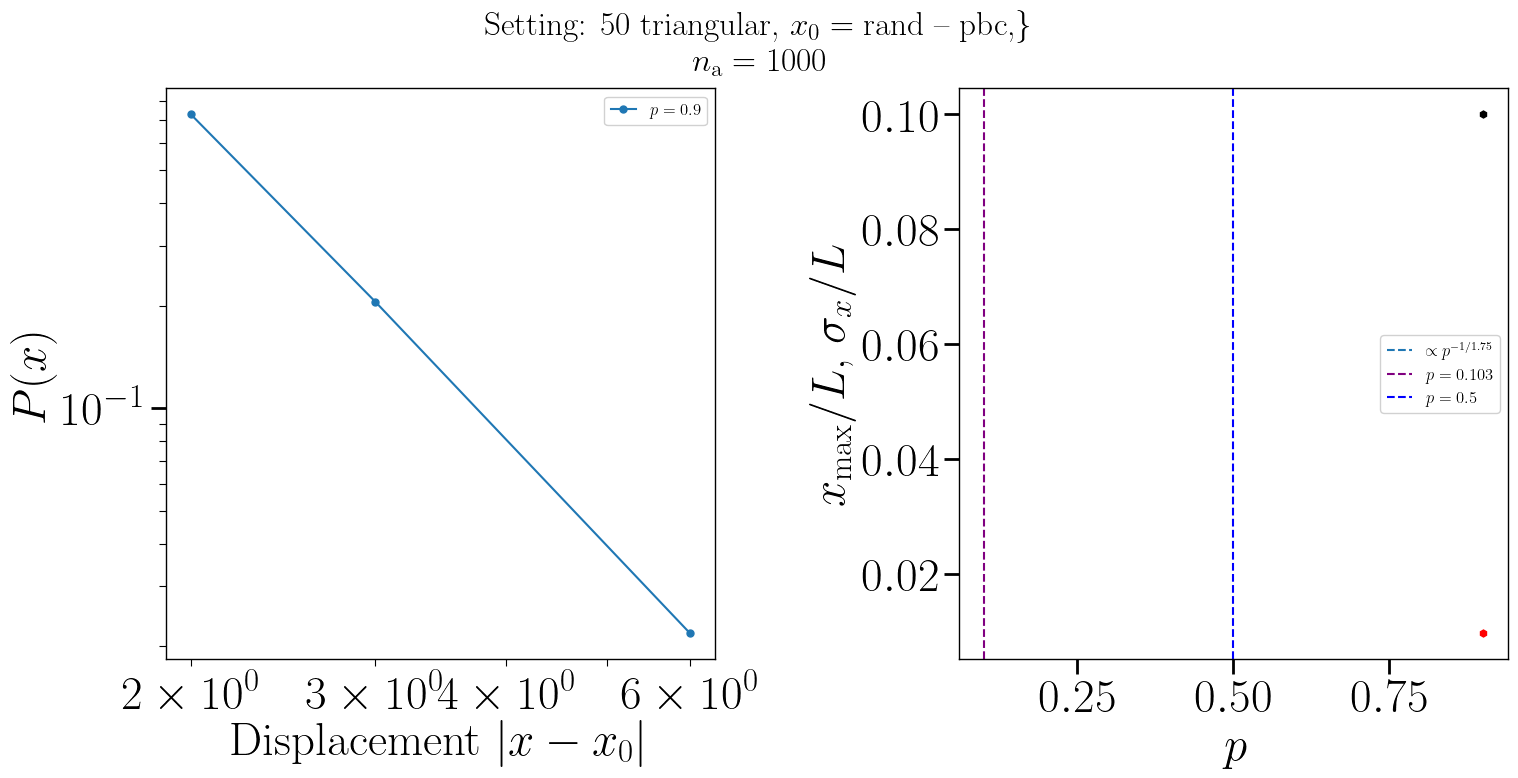

In [ ]:
fname = f'Lattice2DRw_{side}_m{mode}_{geo}_{navg2}.pdf'
strTit = fr'Setting: {side} {geo}, {' -- '.join(setting[mode])},\
    $n_{{\mathrm{{a}}}}= {navg2}$'
#
fig, ax = plt.subplots(ncols=2)
fig.suptitle(strTit, fontsize=24, y=.9)
#
ax[0].set_xlabel(r'Displacement $\abs{x-x_0}$')
ax[1].set_xlabel(r'$p$')
ax[0].set_ylabel(r'$P(x)$')
ax[1].set_ylabel(r'$x_{\max}/L$, $\sigma_x/L$')
#
# ax[1].set_xscale('log')
#
for pflip in pflipList:
    x, pdf = powerlaw.pdf(stD[pflip], xmin=1)
    ax[0].loglog(x[1:], pdf, label=f'$p = {pflip:.3}$')
    ax[1].plot(pflip, np.max(stD[pflip])/l.side1, 'kh')
    ax[1].plot(pflip, np.std(stD[pflip])/l.side1, 'rh')

ax[1].plot(pflipList,0.01*np.array(pflipList)**(-1/1.75), '--', label=r'$\propto p^{-1/1.75}$')
ax[1].axvline(0.1, color='purple', linestyle='--', label=r'$p=0.103$')
ax[1].axvline(0.5, color='b', linestyle='--', label=r'$p=0.5$')

ax[0].legend(ncols=3)
ax[1].legend()
fig.tight_layout()
# fig.savefig(os.path.join(nbpltPath, fname), bbox_inches='tight')

In [29]:
l = Lattice2D(side, geo=geo, pbc=pbc, with_positions=True, pflip=0.9)
l.flip_random_fract_edges()

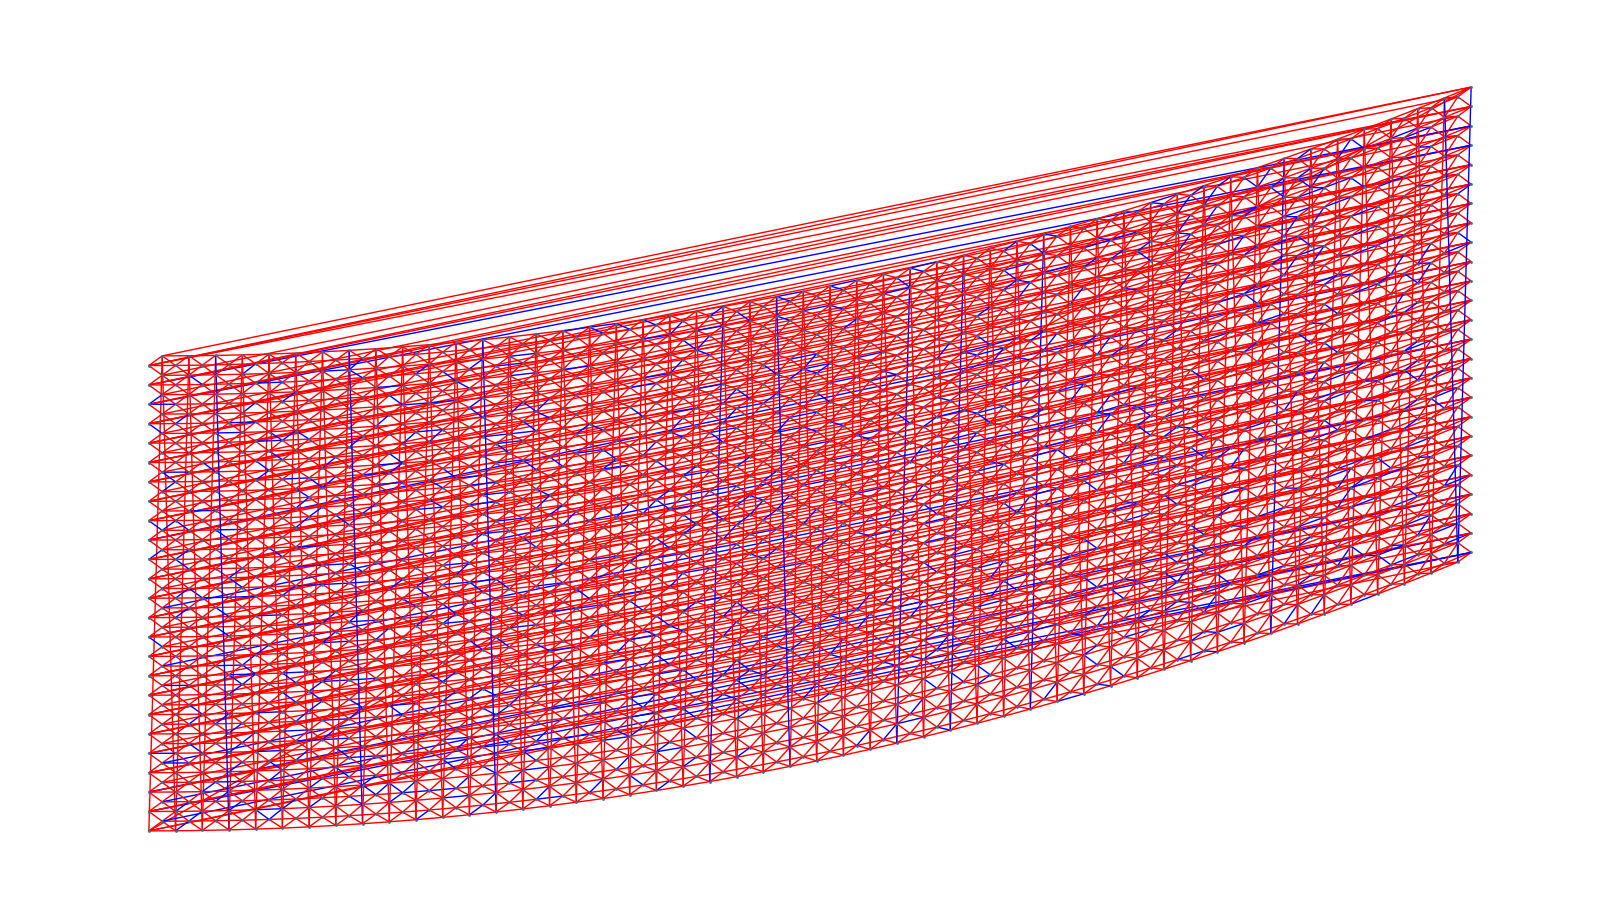

In [30]:
nx.draw(l.G, pos=l.get_node_pos(), edge_color=l.get_edge_color(), node_size=1)

---------------------------

## Misc

In [ ]:
def process_signed_random_walk(data):
    """
    Processes a list of node-sign pairs to determine the distribution of unique nodes
    within clusters of consecutive identical signs.

    Args:
    data (list of tuples): List where each tuple contains a node (as a tuple) and a sign (+1 or -1).

    Returns:
    dict: A dictionary where keys are signs and values are lists of counts of unique nodes per cluster.
    """
    cluster_sizes = defaultdict(list)
    if not data:
        return dict(cluster_sizes)  # Return an empty dictionary if data is empty

    current_cluster = set()
    current_sign = data[0][1]

    for node, sign in data:
        if sign != current_sign:
            # Store size of the current cluster and reset
            cluster_sizes[current_sign].append(len(current_cluster))
            current_cluster = set()
            current_sign = sign
        current_cluster.add(node)

    # Add the last cluster
    cluster_sizes[current_sign].append(len(current_cluster))

    return dict(cluster_sizes)

In [ ]:
def euclidean_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def max_distance(states):
    initial_state = states[0][0]
    max_dist = 0
    
    for state in states:
        current_state = state[0]
        distance = euclidean_distance(initial_state, current_state)
        if distance > max_dist:
            max_dist = distance
    
    return max_dist

In [ ]:
l = Lattice2D(10, pflip=0.5, geo='triangular')
l.flip_random_fract_edges()
srw = SignedRW(l, simTime=100,  stopSim=True,
        initMode="random", 
        runMode="py",
        storeMode="sequential",
        storeFreq=1)

In [ ]:
side = 64
navg = 500
simtime = 10000
pflipList = [0.1, 0.2]

In [ ]:
maDict = {}
for pflip in pflipList:
    maxD = []
    maxL = []
    maDict[pflip] = {}
    for i in range(navg):
        l = Lattice2D(side, pflip=pflip, geo='triangular')
        l.flip_random_fract_edges()
        srw = SignedRW(l, simTime=simtime,  stopSim=True,
                initMode="random", 
                runMode="py",
                storeMode="sequential",
                storeFreq=1)
        srw.run()
        if srw.StopFlag:
            maxD.append(max_distance(srw.s_tList))
            maxL.append(len(srw.s_tList))
    maDict[pflip]['maxD'] = np.array(maxD)
    maDict[pflip]['maxL'] = np.array(maxL)
    # arr = np.array(maxD)
    # arr = arr[arr != 0]
    # maDict[pflip] = {}
    # ['mean'] = np.mean(arr)
    # maDict[pflip]['max'] = max(arr)
    # # fit = powerlaw.Fit(arr)
    # # fit.plot_ccdf(color='b', linewidth=2)
    # edges, hist = powerlaw.pdf(arr)
    # bin_centers = (edges[1:]+edges[:-1])/2.0
    # plt.loglog(bin_centers, hist, label=f"pflip={pflip:.3g}")
# plt.legend()

In [ ]:
for pflip in pflipList:
    arr = maDict[pflip]['maxD']
    arr = arr[arr != 0]
    # arr_sorted = np.sort(arr)
    # # Calculate the CCDF
    # ccdf = np.arange(1, len(arr_sorted) + 1)[::-1] / len(arr_sorted)
    # # Plot the CCDF on a log-log scale
    # plt.loglog(arr_sorted, ccdf, marker='o', linestyle='none')
    edges, hist = powerlaw.ccdf(arr)
    bin_centers = (edges[1:]+edges[:-1])/2.0
    plt.plot(bin_centers, hist, label=f"pflip={pflip:.3g}")
# plt.axvline(63, c='k', ls='--')
# plt.axhline(0.5, c='k', ls='--')
plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.show()

In [ ]:
for pflip in pflipList:
    arr = maDict[pflip]['maxL']
    edges, hist = powerlaw.ccdf(arr)
    # arr_sorted = np.sort(arr)

    # # Calculate the CCDF
    # ccdf = np.arange(1, len(arr_sorted) + 1)[::-1] / len(arr_sorted)

    # # Plot the CCDF on a log-log scale
    # plt.loglog(arr_sorted, ccdf, marker='o', linestyle='none')
    bin_centers = (edges[1:]+edges[:-1])/2.0
    plt.loglog(bin_centers, hist[:-1])

In [ ]:
np.mean(arr)

In [ ]:
l = Lattice2D(side, pflip=pflipList[0], with_positions=True)
l.flip_random_fract_edges()

In [ ]:
nx.draw(l.G, pos=l.get_node_pos(), edge_color=l.get_edge_color())

In [ ]:
side = 12
navg = 100
simtime = 100
pflipList = [0.01, 0.04, 0.06, 0.08, 0.103, 0.25, 0.5]
#
data = {}
#
for pflip in pflipList:
    data[pflip] = []
    for na in range(navg):
        l = Lattice2D(side, pflip=pflip)
        l.flip_random_fract_edges()
        srw = SignedRW(l, simTime=simtime,, stopSim=True, 
                initMode="random", 
                runMode="py",
                storeMode="sequential",
                storeFreq=1)
        srw.run()
        data[pflip].extend(srw.s_tList)
    cluster_sizes = process_signed_random_walk(data[pflip])
    edges, hist = powerlaw.pdf(cluster_sizes[-1], xmin=1)
    bin_centers = (edges[1:]+edges[:-1])/2.0
    plt.loglog(bin_centers, hist)
    edges, hist = powerlaw.pdf(cluster_sizes[1], xmin=1)
    bin_centers = (edges[1:]+edges[:-1])/2.0
    plt.loglog(bin_centers, hist)
    plt.xlabel(r'$\tau$')
    plt.ylabel(r'$P(\tau)$')
    plt.title(fr'$p={pflip:.3g}$')
    plt.show()

In [ ]:
cluster_sizes

In [ ]:
fig, ax = plt.subplots()
l_ini = Lattice2D(32)
mmax = l_ini.Ne//10
for i in range(1, mmax, mmax//8):
    print("Current value of p:", i/l_ini.Ne)  # Debugging statement to check p
    l = Lattice2D(32, pflip=i/l_ini.Ne)
    l.flip_random_fract_edges()
    srw = SignedRW(l, simTime=2000, 
               initMode="random", 
               runMode="py",
               storeMode="sequential",
               storeFreq=1)
    srw.run()
    a = np.array(srw.s_tList, dtype=object)[:, 1].astype(int)
    changes = np.where(np.diff(a) != 0)[0] + 1
    sequence_lengths = np.diff(np.hstack(([0], changes, [len(a)])))
    # print(sequence_lengths)
    # b, h, w = log_binning(sequence_lengths, binnum=15)
    # ax.plot(b, h/w)
    edges, hist = powerlaw.pdf(sequence_lengths, xmin=1)
    bin_centers = (edges[1:]+edges[:-1])/2.0
    ax.loglog(bin_centers, hist)
plt.show()

In [ ]:
fig, ax = plt.subplots()
for p in [0.01, 0.05, 0.08, 0.1, 0.2, 0.5]:
    print("Current value of p:", p)  # Debugging statement to check p
    l = Lattice2D(128, pflip=p)
    l.flip_random_fract_edges()
    srw = SignedRW(l, simTime=2000, 
               initMode="random", 
               runMode="py",
               storeMode="sequential",
               storeFreq=1)
    srw.run()
    a = np.array(srw.s_tList, dtype=object)[:, 1].astype(int)
    changes = np.where(np.diff(a) != 0)[0] + 1
    sequence_lengths = np.diff(np.hstack(([0], changes, [len(a)])))
    print(sequence_lengths)
    # b, h, w = log_binning(sequence_lengths, binnum=15)
    # ax.plot(b, h/w)
    edges, hist = powerlaw.pdf(sequence_lengths)
    bin_centers = (edges[1:]+edges[:-1])/2.0
    ax.loglog(bin_centers, hist)
plt.show()

In [ ]:
b, h, w = log_binning(sequence_lengths, binnum=15)
plt.plot(b, h/w)
plt.yscale("log")
plt.xscale("log")

In [ ]:
a.alpha